In [ ]:
# Homework 4
#
# This homework assignment is for the practice section of homework 4 at the University of Utah in CS6350 Machine Learning.
# This code will covering:
#    1. SVM
#
# Helpful link to understand scipy.minimize: https://www.youtube.com/watch?v=_aNYFXwzFno
#
# @author  Scott Merkley
# @version November 17, 2024

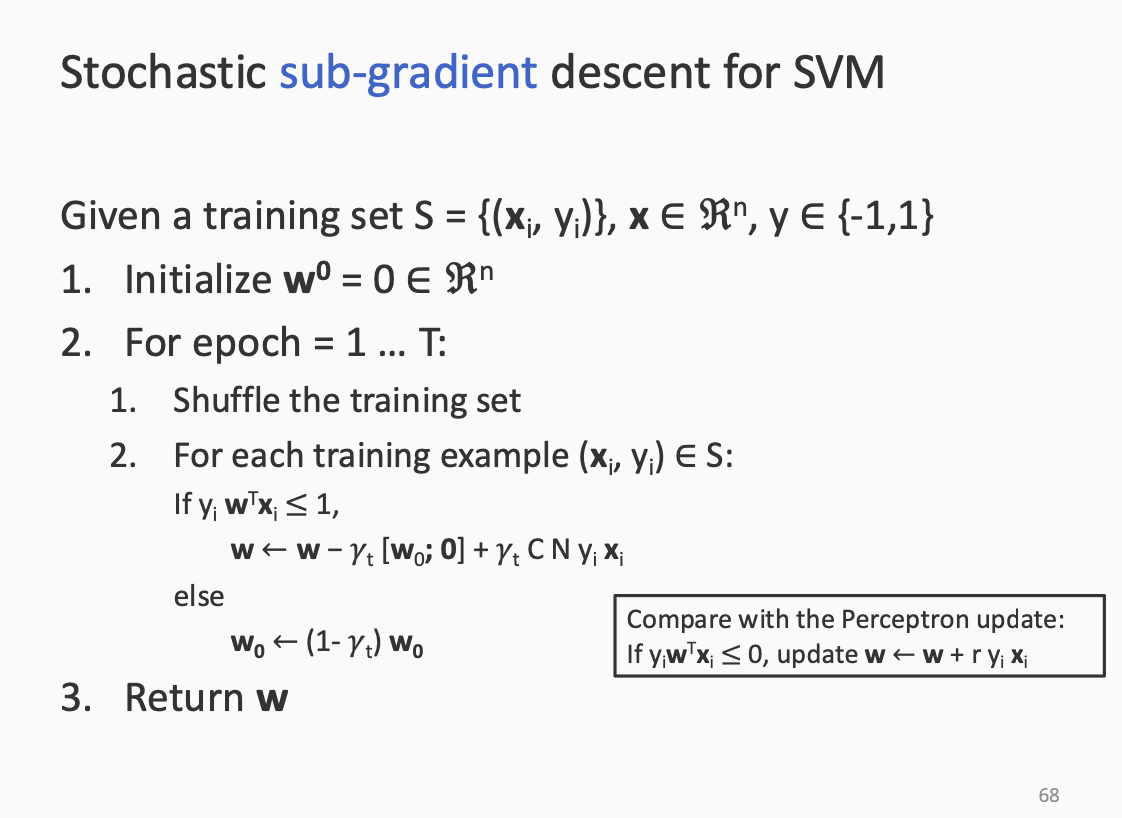

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import minimize

In [ ]:
# Make sure that the file you are trying to download is viewable to anyone with the link.
def Download_From_Google_Drive(file_id):
  return 'https://drive.google.com/uc?export=download&id=' + file_id

# **Creating SVM Class**

In [ ]:
  class SVM:
    def __init__(self, learning_rate_schedule = None, n_epochs = 100, C = 700/873, kernel_method = None, gamma = None):
      self.lrs           = learning_rate_schedule
      self.T             = n_epochs
      self.C             = C
      self.weights       = None
      self.bias          = None
      self.dual_result   = None
      self.kernel_method = kernel_method
      self.gamma         = gamma

    # This helper method initializes the perceptron by finding the number of rows, number of columns, and returning y as an
    # array that contains {-1, 1} instead of {0, 1}. By changing y, you can easily calculate the new weights by just multiplying
    # your learning rate by y[i] instead of having to do math behind the scenes.
    #
    def initialize(self, X, y):
      n_rows, n_columns = X.shape
      y = np.where(y <= 0, -1, 1) # Converting labels to -1 or 1 so it is easier to compute weights and bias
      return n_rows, n_columns, y


    # Train trains the model using the SVM model. This first initializes the weights, then
    # runs the dataset through a number of epochs, calculating predictions and then updating the weights to get a better
    # calculation and predictions when predicting values.
    #
    def train(self, X, y):
      n_rows, n_columns, y = self.initialize(X, y)
      self.weights = np.zeros(n_columns) # Initializing weights to zero
      self.bias    = 0

      for epoch in range(1, self.T + 1):
        # Shuffle the Training Set
        random_idx     = np.random.randint(0, len(X), size = len(X))
        X_temp, y_temp = X[random_idx], y[random_idx]

        lrs_t = 1 / epoch if self.lrs is None else self.lrs(epoch)

        for i in range(len(X_temp)):
          margin = y_temp[i] * np.dot(self.weights, X_temp[i])

          # Update Weights
          if margin <= 1:
            self.weights = self.weights - lrs_t * self.bias + lrs_t * self.C * len(X_temp) * y_temp[i] * X_temp[i]
          else:
            self.bias = (1 - lrs_t) * self.bias

        self.update_user(epoch)


    # Defining the kernel to use for the Dual SVM model.
    #
    def kernel(self, x1, x2):
      if self.kernel_method == 'Gaussian':
        gamma = 0.1 if self.gamma == None else self.gamma
        return np.exp(-np.dot(x1, x2.T)**2 / gamma)
      else:
        return np.dot(x1, x2.T)


    # Defining the objective function for the SVM
    #
    def objective_function(self, alpha, Q):
      return -np.sum(alpha) + 1/2 * np.dot(alpha, np.dot(Q, alpha))


    def constraints(self, alpha, y):
      return np.dot(alpha, y)


    # Train the SVM model using the Dual Model on the X data
    #
    def train_dual(self, X, y):
      n_rows, n_columns, y = self.initialize(X, y)
      N = len(y)
      Q = np.outer(y, y) * self.kernel(X, X)
      bounds = [(0, self.C)] * N
      constraint = {'type' : 'eq', 'fun' : self.constraints, 'args' : (y,)}
      initial_guess = np.zeros(N)

      self.dual_result = minimize(self.objective_function, initial_guess, args = (Q,), bounds = bounds, constraints = constraint, method = 'SLSQP')


    # Prints out 'Current epoch: #' to the user in steps but will only print out 10 total steps depending
    # on the number of epochs initialized in the perceptron.
    #
    def update_user(self, epoch):
      # Visually Update
      if epoch % (self.T // 10) == 0 and False:
        print(f'Current epoch: {epoch}')


    # Returns the weights and bias to the user.
    #
    def get_weights_and_bias(self, X, y, alphas):
      self.weights = np.sum(alphas[:, None] * y[:, None] * X, axis = 0)
      support_vector_indices = np.where((alphas > 1e-5) & (alphas < self.C))[0][0]
      self.bias = np.mean(y_train[support_vector_indices] - np.dot(self.weights, X_train[support_vector_indices]))
      return self.weights, self.bias


    # Predicts the next value given a test example X.
    #
    def predict(self, X):
      return (np.sign(np.dot(X, self.weights) + self.bias) + 1) // 2

    # Predicts the next value given a test example X using the Dual Model.
    #
    def predict_dual(self, X_test, X_train, y_train, alphas):
      self.weights = np.sum(alphas[:, None] * y_train[:, None] * X_train, axis = 0)
      support_vector_indices = np.where((alphas > 1e-5) & (alphas < self.C))[0][0]
      self.bias = np.mean(y_train[support_vector_indices] - np.dot(self.weights, X_train[support_vector_indices]))
      return (np.sign(np.sum((alphas * y_train)[:, None] * self.kernel(X_train, X_test) + self.bias, axis = 0)) + 1) // 2

# **Downloading bank-note.csv from Google Drive**

In [ ]:
columns = ["Variance", "Skewness", "Curtosis", "Entropy", "Label"]
bank_note_train = pd.read_csv(Download_From_Google_Drive('1Du3SiMaZGn-HuvFUJchE6NNwiIdRlQbh'), names = columns)
bank_note_test = pd.read_csv(Download_From_Google_Drive('1mX8lXt2TvYGyDBihyGOTMnYRiGdzeoKr'), names = columns)
bank_note_train

,Variance,Skewness,Curtosis,Entropy,Label
0,3.848100,10.15390,-3.85610,-4.22280,0
1,4.004700,0.45937,1.36210,1.61810,0
2,-0.048008,-1.60370,8.47560,0.75558,0
3,-1.266700,2.81830,-2.42600,-1.88620,1
4,2.203400,5.99470,0.53009,0.84998,0
...,...,...,...,...,...
867,0.273310,4.87730,-4.91940,-5.81980,1
868,1.063700,3.69570,-4.15940,-1.93790,1
869,-1.242400,-1.71750,-0.52553,-0.21036,1
870,1.837300,6.12920,0.84027,0.55257,0


# **Set Training and Test Datasets**

In [ ]:
# Training Datasets
X_train = bank_note_train.drop('Label', axis = 1).values
y_train = bank_note_train['Label'].values

# Testing Datasets
X_test = bank_note_test.drop('Label', axis = 1).values
y_test = bank_note_test['Label'].values

# **Defining $C$**

In [ ]:
C = [100/873, 500/873, 700/873]

# **2a) Using Schedule Learning Rate  $\;\;\;\;\ \gamma_t = \frac{\gamma_0}{1 + \frac{\gamma_0}{\alpha}t}$**

In [ ]:
def Learning_Rate_Schedule(t):
  gamma_0 = 9.5
  a       = 3.5
  return gamma_0 / (1 + gamma_0 / a * t)

lrs_1 = []
for c in C:
  svm = SVM(C = c, learning_rate_schedule = Learning_Rate_Schedule)
  svm.train(X_train, y_train)

  print('\nWeights:', svm.weights)
  print('Bias:', svm.bias)
  correct = sum(y_test == svm.predict(X_test))
  print(f"Percent Correct: {correct / len(X_test) * 100:0.3}%")
  svm_prediction_error = correct / len(X_test)
  lrs_1.append(svm_prediction_error)


Weights: [-447.54105776 -330.73297646 -400.66654557 -155.55358032]
Bias: -0.0
Percent Correct: 90.6%

Weights: [-719.02186854 -616.19072382 -591.24469712 -258.66597803]
Bias: 0.0
Percent Correct: 94.4%

Weights: [-2380.60988149 -1686.92481994 -1815.53017989  -857.81707749]
Bias: 0.0
Percent Correct: 94.8%


# **2b) Using Schedule Learning Rate  $\;\;\;\;\ \gamma_t = \frac{\gamma_0}{1 + t}$**

In [ ]:
def Learning_Rate_Schedule(t):
  gamma_0 = 9.5
  return gamma_0 / (1 + t)

lrs_2 = []
for c in C:
  svm = SVM(C = c, learning_rate_schedule = Learning_Rate_Schedule)
  svm.train(X_train, y_train)

  print('\nWeights:', svm.weights)
  print('Bias:', svm.bias)
  correct = sum(y_test == svm.predict(X_test))
  print(f"Percent Correct: {correct / len(X_test) * 100:0.3}%")
  svm_prediction_error = correct / len(X_test)
  lrs_2.append(svm_prediction_error)


Weights: [-381.72895488 -229.61229579 -248.83735276 -132.54347826]
Bias: -0.0
Percent Correct: 95.6%

Weights: [-1956.34464325 -1405.75014304 -1219.95687237  -889.54664856]
Bias: 0.0
Percent Correct: 94.0%

Weights: [-3090.1301572  -2132.76388747 -1609.02179123 -1402.05314834]
Bias: -0.0
Percent Correct: 93.0%


# **2c)** For each $C$, report the model parameters learned from the two learning rate schedules, as well as the differences between the training / test errors. What can you conclude?

In [ ]:
for c, lrs_1i, lrs_2i in zip(C, lrs_1, lrs_2):
  diff = (1 - lrs_1i) * 100 - (1 - lrs_2i) * 100
  print(f'C: {c:0.3}, lrs_1: {(1 - lrs_1i) * 100:0.2}%, lrs_2: {(1 - lrs_2i) * 100:0.2}%, diff: {diff:0.2}%')

C: 0.115, lrs_1: 9.4%, lrs_2: 4.4%, diff: 5.0%
C: 0.573, lrs_1: 5.6%, lrs_2: 6.0%, diff: -0.4%
C: 0.802, lrs_1: 5.2%, lrs_2: 7.0%, diff: -1.8%


# **3a) Implementing SVM in the Dual Domain**

In [ ]:
for c in C:
  svm = SVM(C = c)
  svm.train_dual(X_train, y_train)
  # print('\nResult:', svm.dual_result)

  alpha = svm.dual_result.x
  w, b = svm.get_weights_and_bias(X_train, y_train, alpha)
  print(f'C: {c}, Weights: {w}, Bias: {b}')
  correct = sum(y_test == svm.predict_dual(X_test, X_train, y_train, alpha))
  print(f"Percent Correct: {correct / len(X_test) * 100:0.3}%")
  correct = sum(y_test == svm.predict(X_test))
  print(f"Percent Correct: {correct / len(X_test) * 100:0.3}%")
  # svm_prediction_error = correct / len(X_test)

C: 0.1145475372279496, Weights: [-0.1775125  -1.82622093  4.31318644 -3.09296176], Bias: -108.2280141013814
Percent Correct: 55.8%
Percent Correct: 56.2%
C: 0.572737686139748, Weights: [  1.39882787  -5.78304285  12.79562879 -10.97725929], Bias: -325.5912534245578
Percent Correct: 55.8%
Percent Correct: 56.2%
C: 0.8018327605956472, Weights: [  2.31057278 -10.15504828  18.71841349 -13.44148494], Bias: -492.44325740426655
Percent Correct: 55.8%
Percent Correct: 56.2%


# **3b) Using the Gaussian Kernel in the dual form to implement the nonlinear SVM**

# **$$\;\;\;\;\; k(x_i, x_j) = exp\left(-\frac{||x_i - x_j||^2}{\gamma}\right)$$**

In [ ]:
for c in C:
  svm = SVM(C = c, kernel_method = 'Gaussian')
  svm.train_dual(X_train, y_train)
  # print('\nResult:', svm.dual_result)

  alpha = svm.dual_result.x
  w, b = svm.get_weights_and_bias(X_train, y_train, alpha)
  print(f'C: {c}, Weights: {w}, Bias: {b}')
  correct = sum(y_test == svm.predict_dual(X_test, X_train, y_train, alpha))
  print(f"Percent Correct: {correct / len(X_test) * 100:0.3}%")
  correct = sum(y_test == svm.predict(X_test))
  print(f"Percent Correct: {correct / len(X_test) * 100:0.3}%")
  # svm_prediction_error = correct / len(X_test)

C: 0.1145475372279496, Weights: [-78.4065978  -42.38040332  89.47293155 -53.32287814], Bias: 851.8875277839197
Percent Correct: 44.2%
Percent Correct: 49.4%
C: 0.572737686139748, Weights: [-376.12192367 -207.46586538  441.64035413 -264.63559516], Bias: 4139.448603327953
Percent Correct: 44.2%
Percent Correct: 49.4%
C: 0.8018327605956472, Weights: [-510.77275963 -282.19096231  601.77635233 -363.7373847 ], Bias: 5615.363032689814
Percent Correct: 44.2%
Percent Correct: 49.6%


# **3c) Compare $\gamma$ and $C$ values and overlaps**

In [ ]:
gamma_values = [0.1, 0.5, 1, 5, 100]

for gamma in gamma_values:
  for c in C:
    svm = SVM(C = c, kernel_method = 'Gaussian', gamma = gamma)
    svm.train_dual(X_train, y_train)
    # print('\nResult:', svm.dual_result)

    alpha = svm.dual_result.x
    w, b = svm.get_weights_and_bias(X_train, y_train, alpha)
    print(f'C: {c}, Weights: {w}, Bias: {b}')
    correct = sum(y_test == svm.predict_dual(X_test, X_train, y_train, alpha))
    print(f"Percent Correct: {correct / len(X_test) * 100:0.3}%")
    correct = sum(y_test == svm.predict(X_test))
    print(f"Percent Correct: {correct / len(X_test) * 100:0.3}%")
    # svm_prediction_error = correct / len(X_test)

C: 0.1145475372279496, Weights: [-78.4065978  -42.38040332  89.47293155 -53.32287814], Bias: 851.8875277839197
Percent Correct: 44.2%
Percent Correct: 49.4%
C: 0.572737686139748, Weights: [-376.12192367 -207.46586538  441.64035413 -264.63559516], Bias: 4139.448603327953
Percent Correct: 44.2%
Percent Correct: 49.4%
C: 0.8018327605956472, Weights: [-510.77275963 -282.19096231  601.77635233 -363.7373847 ], Bias: 5615.363032689814
Percent Correct: 44.2%
Percent Correct: 49.6%


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


C: 0.1145475372279496, Weights: [-78.09629654 -42.10069885  89.94342147 -53.31245237], Bias: -79.40647489656172
Percent Correct: 55.8%
Percent Correct: 69.8%
C: 0.572737686139748, Weights: [-367.66007945 -202.57114437  436.7185913  -264.12126526], Bias: 4040.3791755228485
Percent Correct: 44.2%
Percent Correct: 49.6%
C: 0.8018327605956472, Weights: [-509.80324743 -287.16350801  610.4796942  -367.37632451], Bias: 1936.4406048688907
Percent Correct: 44.2%
Percent Correct: 65.8%
C: 0.1145475372279496, Weights: [-77.96456802 -41.96749003  90.02835388 -53.36285615], Bias: -250.39053700113988
Percent Correct: 55.8%
Percent Correct: 71.8%
C: 0.572737686139748, Weights: [-363.84055468 -199.15314904  433.03526191 -266.18997659], Bias: 3968.0362388846547
Percent Correct: 44.2%
Percent Correct: 49.4%
C: 0.8018327605956472, Weights: [-506.53283586 -283.22448842  608.00224475 -369.98912837], Bias: 934.7263843600259
Percent Correct: 44.2%
Percent Correct: 69.2%
C: 0.1145475372279496, Weights: [-75.6